1. Import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

2. Read the datasets

In [2]:
df=pd.read_csv("ADA-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-09-05,0.045504,0.045543,0.043959,0.044437,0.044437,47778879.0
1,2019-09-06,0.044437,0.044763,0.043793,0.044415,0.044415,44478145.0
2,2019-09-07,0.044426,0.046585,0.043849,0.046198,0.046198,40837132.0
3,2019-09-08,0.046211,0.047653,0.046211,0.046719,0.046719,46948887.0
4,2019-09-09,0.046706,0.047211,0.045501,0.046931,0.046931,64445050.0


3. Analyze the closing prices from dataframe:

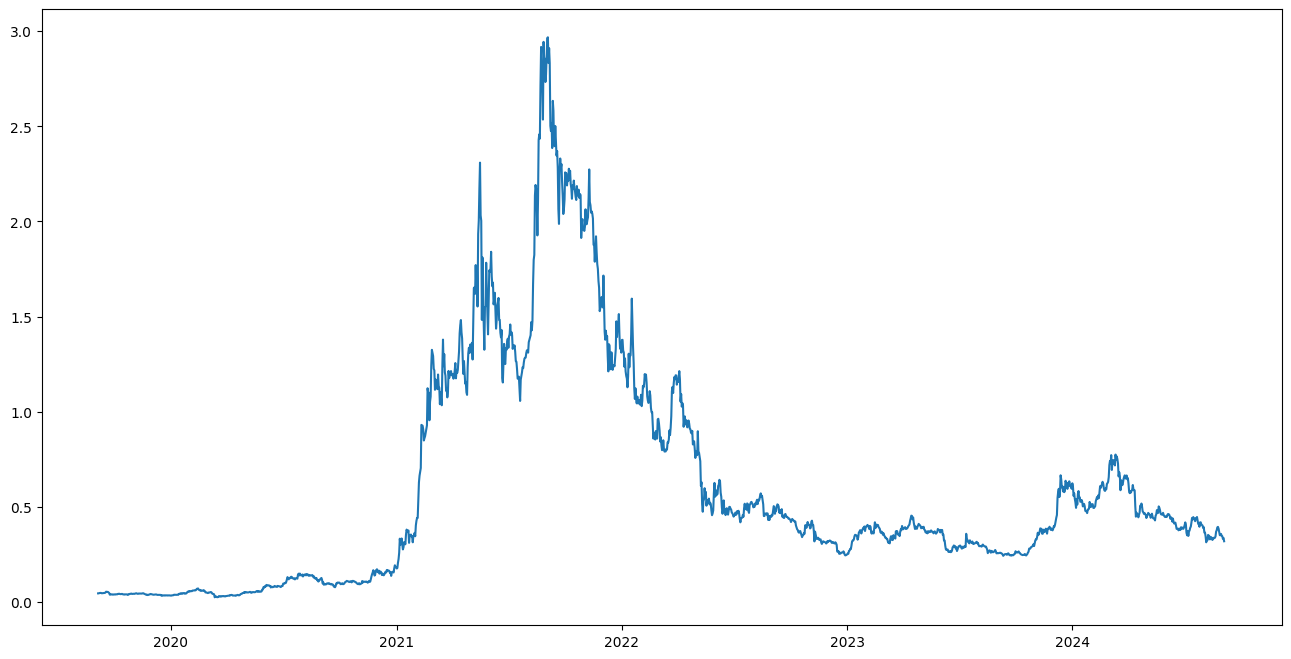

In [3]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

4. Sort the dataset on date time and filter “Date” and “Close” columns:

In [4]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

C:\Users\hp\AppData\Local\Temp\ipykernel_16456\2947567375.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_dataset["Date"][i]=data['Date'][i]
C:\Users\hp\AppData\Local\Temp\ipykernel_16456\2947567375.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a

5. Normalize the new filtered dataset:

In [5]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\pandas\core\indexes\base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


6. Build and train the LSTM model:



In [6]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


927/927 - 31s - 34ms/step - loss: 0.0034


7. Take a sample of a dataset to make stock price predictions using the LSTM model:

In [7]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

print(f"Shape of X_test before reshape: {X_test.shape}")
# Check if X_test has the expected shape
if len(X_test.shape) == 2:
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
else:
    print("Unexpected shape of X_test:", X_test.shape)
# Check the target value in the Progbar update function
try:
    closing_price = lstm_model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
except ValueError as e:
    print(f"Error during prediction: {e}")



Shape of X_test before reshape: (841, 60)
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


8. Save the LSTM model:

In [8]:
lstm_model.save("ADA_USD.h5")

9. Visualize the predicted stock costs with actual stock costs:

Length of closing_price: 841
Length of valid_data: 841


C:\Users\hp\AppData\Local\Temp\ipykernel_16456\1128379164.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = closing_price


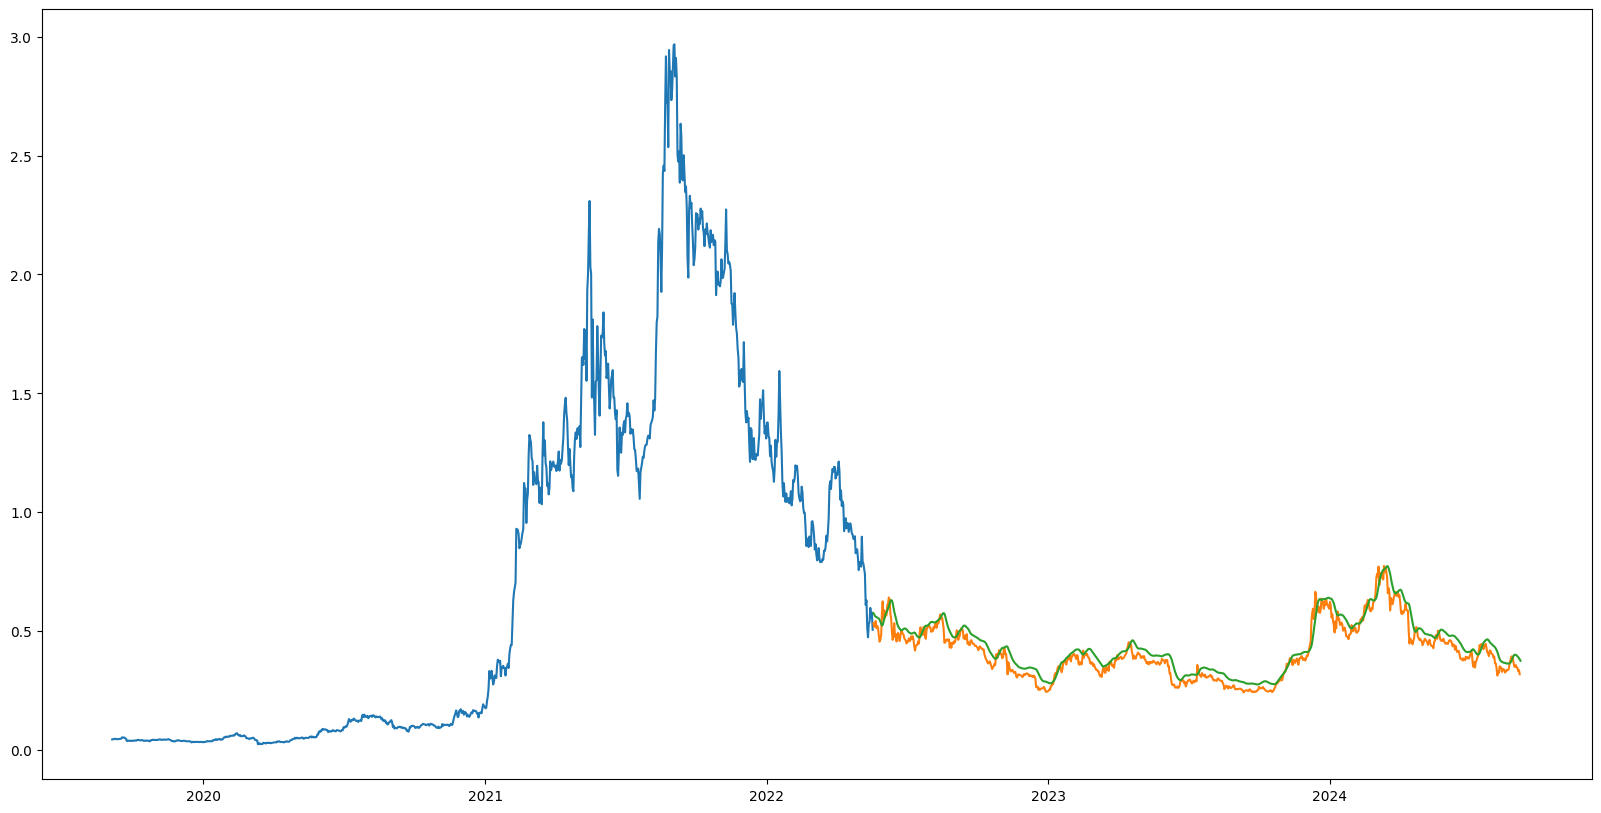

In [9]:
if 'closing_price' in locals():
    train_data = new_dataset[:987]
    valid_data = new_dataset[987:]

    # Đảm bảo closing_price là mảng 1 chiều
    closing_price = closing_price.flatten()

    # Kiểm tra độ dài của closing_price và valid_data
    print(f"Length of closing_price: {len(closing_price)}")
    print(f"Length of valid_data: {len(valid_data)}")

    # Thêm cột 'Predictions' nếu độ dài khớp
    if len(closing_price) == len(valid_data):
        valid_data['Predictions'] = closing_price
    else:
        print("Length mismatch between closing_price and valid_data")
        print("Cannot add 'Predictions' column due to length mismatch.")

    plt.plot(train_data["Close"])
    plt.plot(valid_data[['Close',"Predictions"]])
    plt.show()